In [1]:
# Install additional required libraries
!pip install newsapi-python textblob wordcloud

# Download NLTK data
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# Download TextBlob corpora
!python -m textblob.download_corpora

print("✓ All libraries installed!")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.
✓ All libraries installed!


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# ML libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Visualization
from wordcloud import WordCloud

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All imports successful!")

✓ All imports successful!


In [5]:
# Install NewsAPI
from newsapi import NewsApiClient

# YOUR API KEY HERE
# Get free key from: https://newsapi.org/
API_KEY = '87f32a82b0854fbfa9800207c79f901e'  #  Replace this!

newsapi = NewsApiClient(api_key=API_KEY)

print("✓ NewsAPI connected!")

✓ NewsAPI connected!


In [6]:
def collect_news_data():
    """Collect news from multiple categories"""

    categories = ['technology', 'business', 'sports', 'entertainment', 'health']
    all_articles = []

    # Date range
    end_date = datetime.now()
    start_date = end_date - timedelta(days=7)

    print(" Collecting news articles...\n")

    for category in categories:
        print(f"Fetching {category} news...", end=" ")

        try:
            articles = newsapi.get_everything(
                q=category,
                from_param=start_date.strftime('%Y-%m-%d'),
                to=end_date.strftime('%Y-%m-%d'),
                language='en',
                sort_by='publishedAt',
                page_size=100
            )

            for article in articles['articles']:
                all_articles.append({
                    'title': article['title'],
                    'description': article['description'],
                    'content': article['content'],
                    'source': article['source']['name'],
                    'category': category,
                    'published_at': article['publishedAt'],
                    'url': article['url']
                })

            print(f"✓ {len(articles['articles'])} articles")

        except Exception as e:
            print(f"✗ Error: {e}")

    # Create DataFrame
    df = pd.DataFrame(all_articles)

    # Clean data
    df = df.drop_duplicates(subset=['title'])
    df = df.dropna(subset=['title', 'description'])

    print(f"\n✓ Total collected: {len(df)} articles")

    return df

# Collect data
df_raw = collect_news_data()

# Display first few rows
df_raw.head()

🔍 Collecting news articles...

Fetching technology news... ✓ 96 articles
Fetching business news... ✓ 93 articles
Fetching sports news... ✓ 99 articles
Fetching entertainment news... ✓ 99 articles
Fetching health news... ✓ 95 articles

✓ Total collected: 432 articles


,title,description,content,source,category,published_at,url
0,The shape of artificial intelligence,They say the shape of things only becomes legi...,I. Spooky shapes at a distance\r\nThe shape of...,Thealgorithmicbridge.com,technology,2025-12-24T07:44:03Z,https://www.thealgorithmicbridge.com/p/the-sha...
1,"‘Very, very strange time’: After a big 2025, w...","A year of rising profits, rising Pentagon dema...",Perhaps the only way to cap a precedent-breaki...,Defense One,technology,2025-12-24T07:37:15Z,https://www.defenseone.com/business/2025/12/ve...
2,"Sensex, Nifty 50 flat ahead of Christmas holid...","Hindalco, Shriram Finance, Apollo Hospitals, T...",Domestic markets traded flat after recording m...,BusinessLine,technology,2025-12-24T07:33:28Z,https://www.thehindubusinessline.com/markets/s...
3,Same Day Instant Cash Advance Loans for Bad Cr...,"SAN DIEGO, Dec. 24, 2025 (GLOBE NEWSWIRE) -- M...","SAN DIEGO, Dec. 24, 2025 (GLOBE NEWSWIRE) -- M...",GlobeNewswire,technology,2025-12-24T07:31:00Z,https://www.globenewswire.com/news-release/202...
4,"Flat-Fee Planning for Physicians, and Why the ...",Financial planning can get complex. But does t...,"Not everyone needs a financial advisor, but fo...",Whitecoatinvestor.com,technology,2025-12-24T07:30:43Z,https://www.whitecoatinvestor.com/flat-fee-pla...


In [7]:
# Data overview
print(" Dataset Overview:\n")
print(f"Total articles: {len(df_raw)}")
print(f"Date range: {df_raw['published_at'].min()} to {df_raw['published_at'].max()}")
print(f"\nCategories distribution:")
print(df_raw['category'].value_counts())
print(f"\nTop sources:")
print(df_raw['source'].value_counts().head(10))

 Dataset Overview:

Total articles: 432
Date range: 2025-12-23T22:30:22Z to 2025-12-24T07:47:38Z

Categories distribution:
category
sports           95
technology       94
entertainment    90
health           79
business         74
Name: count, dtype: int64

Top sources:
source
Lifesciencesworld.com    43
The Times of India       35
CinemaBlend              17
Slashdot.org             17
GlobeNewswire            12
The Irish Times          10
Yahoo Entertainment       9
The Punch                 7
BBC News                  6
Livemint                  6
Name: count, dtype: int64


In [8]:
class TextPreprocessor:
    """Handle all text preprocessing"""

    def __init__(self):
        self.stop_words = set(stopwords.words('english'))

    def clean_text(self, text):
        """Clean and normalize text"""
        if pd.isna(text):
            return ""

        text = text.lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
        text = re.sub(r'<.*?>', '', text)  # Remove HTML
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special chars
        text = ' '.join(text.split())  # Remove extra spaces

        return text

    def remove_stopwords(self, text):
        """Remove common stopwords"""
        tokens = word_tokenize(text)
        filtered = [word for word in tokens if word not in self.stop_words and len(word) > 2]
        return ' '.join(filtered)

    def preprocess(self, df):
        """Preprocess entire dataframe"""
        print(" Preprocessing text data...\n")

        # Combine title and description
        df['text'] = df['title'].fillna('') + ' ' + df['description'].fillna('')

        # Clean
        print("Cleaning text...", end=" ")
        df['cleaned_text'] = df['text'].apply(self.clean_text)
        print("Yes")

        # Remove stopwords
        print("Removing stopwords...", end=" ")
        df['processed_text'] = df['cleaned_text'].apply(self.remove_stopwords)
        print("Yes")

        # Remove empty
        df = df[df['processed_text'].str.len() > 10]

        print(f"\n Preprocessing complete! {len(df)} articles ready.")

        return df

# Preprocess data
preprocessor = TextPreprocessor()
df_processed = preprocessor.preprocess(df_raw)

# Show example
print("\n Example:")
print("Original:", df_processed.iloc[0]['text'][:150])
print("\nProcessed:", df_processed.iloc[0]['processed_text'][:150])

 Preprocessing text data...

Cleaning text... Yes
Removing stopwords... Yes

 Preprocessing complete! 432 articles ready.

 Example:
Original: The shape of artificial intelligence They say the shape of things only becomes legible at a distance.

Processed: shape artificial intelligence say shape things becomes legible distance


 Analyzing sentiment with TextBlob...

Sentiment Distribution:
sentiment
positive    215
neutral     175
negative     42
Name: count, dtype: int64

Average polarity: 0.129


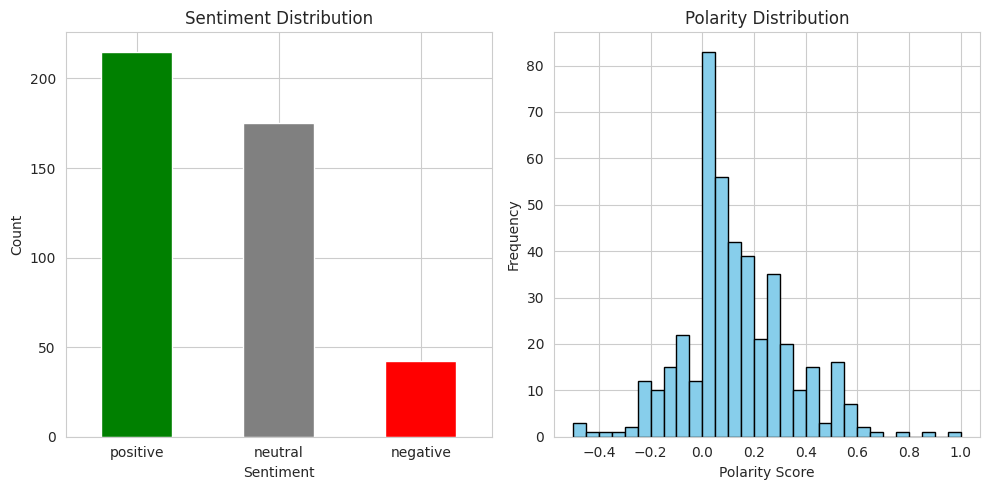

In [9]:
def get_sentiment_textblob(text):
    """Get sentiment using TextBlob"""
    try:
        blob = TextBlob(str(text))
        polarity = blob.sentiment.polarity

        if polarity > 0.1:
            return 'positive', polarity
        elif polarity < -0.1:
            return 'negative', polarity
        else:
            return 'neutral', polarity
    except:
        return 'neutral', 0.0

print(" Analyzing sentiment with TextBlob...\n")

# Apply sentiment analysis
df_processed[['sentiment', 'polarity']] = df_processed['text'].apply(
    lambda x: pd.Series(get_sentiment_textblob(x))
)

# Show distribution
print("Sentiment Distribution:")
print(df_processed['sentiment'].value_counts())
print(f"\nAverage polarity: {df_processed['polarity'].mean():.3f}")

# Visualize
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
df_processed['sentiment'].value_counts().plot(kind='bar', color=['green', 'gray', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
df_processed['polarity'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Polarity Distribution')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [10]:
# Create TF-IDF features
print(" Training custom sentiment classifier...\n")

vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df_processed['processed_text'])
y = df_processed['sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples\n")

# Train models
print("Training Naive Bayes...", end=" ")
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_pred)
print(f"Accuracy: {nb_accuracy:.2%}")

print("Training Logistic Regression...", end=" ")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)
print(f"Accuracy: {lr_accuracy:.2%}")

# Choose best
if lr_accuracy > nb_accuracy:
    best_model = lr_model
    best_pred = lr_pred
    model_name = "Logistic Regression"
else:
    best_model = nb_model
    best_pred = nb_pred
    model_name = "Naive Bayes"

print(f"\n Best model: {model_name} with {max(nb_accuracy, lr_accuracy):.2%} accuracy")

 Training custom sentiment classifier...

Training set: 345 samples
Test set: 87 samples

Training Naive Bayes... Accuracy: 59.77%
Training Logistic Regression... Accuracy: 60.92%

 Best model: Logistic Regression with 60.92% accuracy


 Classification Report:

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         9
     neutral       0.64      0.46      0.53        35
    positive       0.60      0.86      0.70        43

    accuracy                           0.61        87
   macro avg       0.41      0.44      0.41        87
weighted avg       0.55      0.61      0.56        87



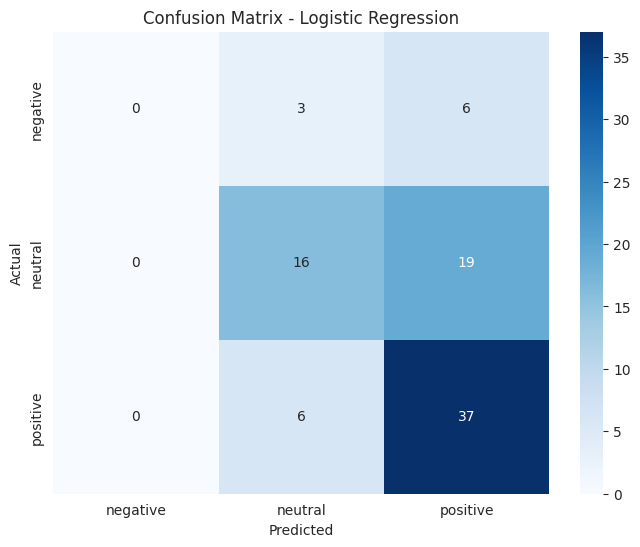

In [11]:
# Classification report
print(" Classification Report:\n")
print(classification_report(y_test, best_pred))

# Confusion matrix
cm = confusion_matrix(y_test, best_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.title(f'Confusion Matrix - {model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

 Performing topic clustering...



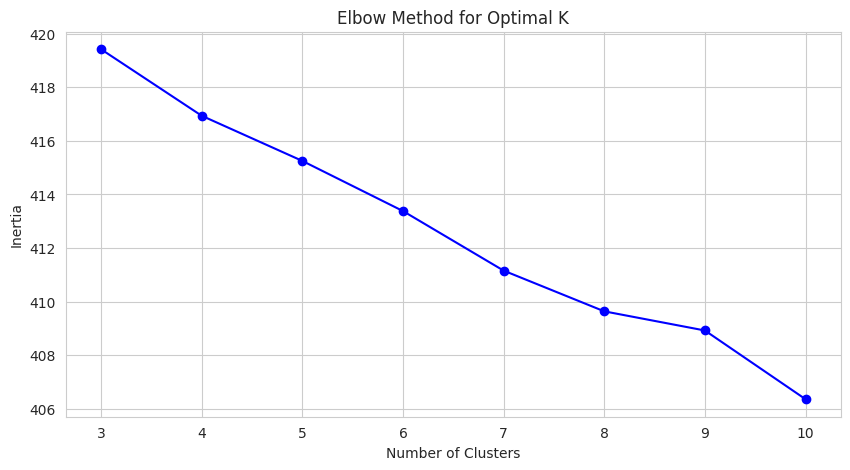

 Using 6 clusters


In [13]:
print(" Performing topic clustering...\n")

# Determine optimal clusters (elbow method)
inertias = []
K_range = range(3, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Plot elbow
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

# Choose optimal K (let's say 5-7)
optimal_k = 6
print(f" Using {optimal_k} clusters")

In [14]:
# Apply K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_processed['cluster'] = kmeans.fit_predict(X)

print(f" Clustering complete!\n")
print("Cluster distribution:")
print(df_processed['cluster'].value_counts().sort_index())

# Get top terms per cluster
feature_names = vectorizer.get_feature_names_out()

print("\n Top terms per cluster:")
for i in range(optimal_k):
    cluster_center = kmeans.cluster_centers_[i]
    top_indices = cluster_center.argsort()[-10:][::-1]
    top_terms = [feature_names[idx] for idx in top_indices]
    print(f"\nCluster {i}: {', '.join(top_terms[:7])}")

 Clustering complete!

Cluster distribution:
cluster
0     13
1    237
2     35
3     53
4     46
5     48
Name: count, dtype: int64

 Top terms per cluster:

Cluster 0: return, bowl, set, alabama, coach, football, practice

Cluster 1: new, home, get, december, one, india, like

Cluster 2: health, could, care, human, people, young, former

Cluster 3: christmas, best, day, christmas day, time, games, year

Cluster 4: power, future, free, key, energy, intelligence, top

Cluster 5: world, year, many, trump, loltron, factory, president


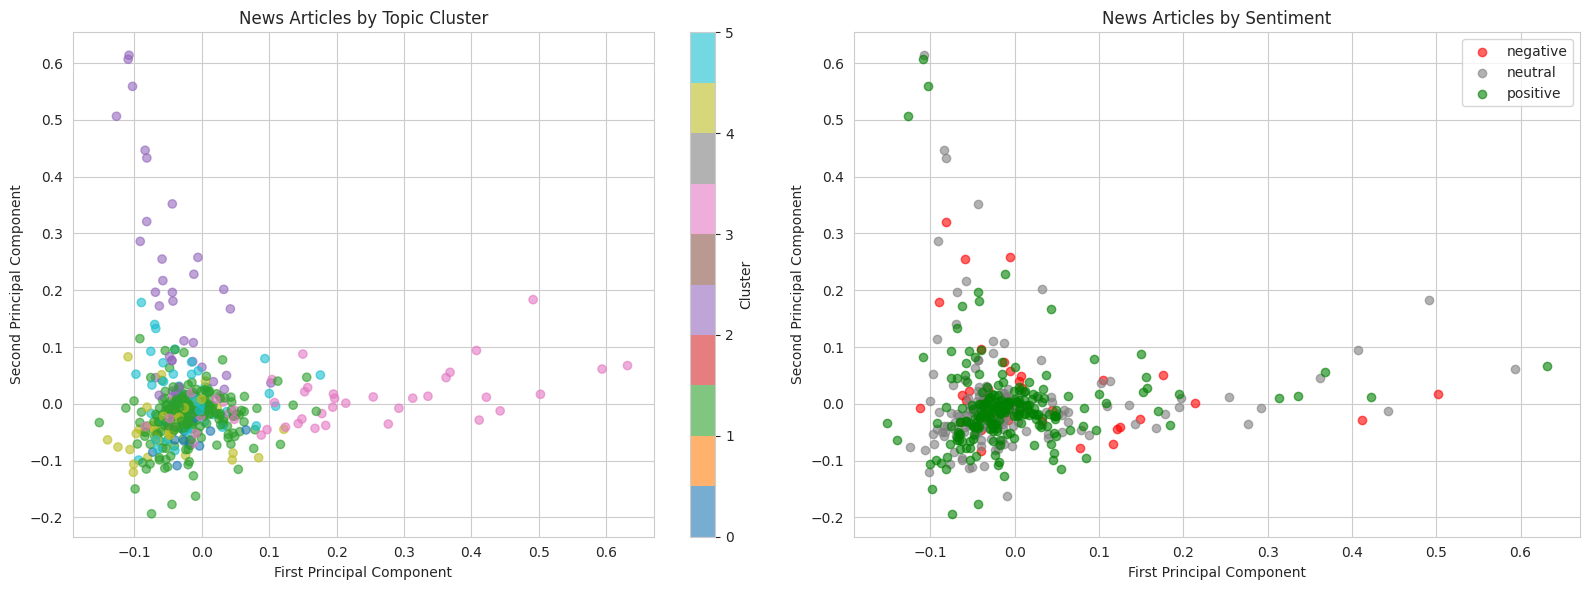

In [15]:
# PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())

# Create visualization dataframe
viz_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'cluster': df_processed['cluster'],
    'sentiment': df_processed['sentiment']
})

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# By cluster
scatter1 = axes[0].scatter(viz_df['PC1'], viz_df['PC2'],
                           c=viz_df['cluster'], cmap='tab10', alpha=0.6)
axes[0].set_title('News Articles by Topic Cluster')
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# By sentiment
sentiment_colors = {'positive': 'green', 'neutral': 'gray', 'negative': 'red'}
for sentiment in viz_df['sentiment'].unique():
    mask = viz_df['sentiment'] == sentiment
    axes[1].scatter(viz_df[mask]['PC1'], viz_df[mask]['PC2'],
                    label=sentiment, alpha=0.6, c=sentiment_colors[sentiment])
axes[1].set_title('News Articles by Sentiment')
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Second Principal Component')
axes[1].legend()

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

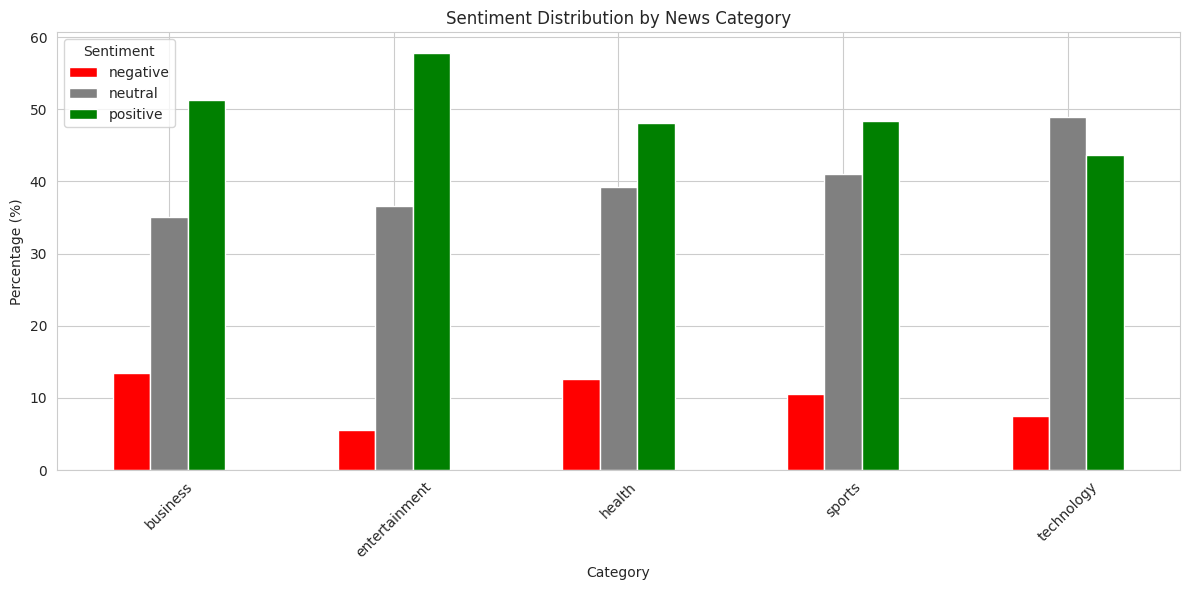


 Sentiment by Category (%):
sentiment      negative  neutral  positive
category                                  
business           13.5     35.1      51.4
entertainment       5.6     36.7      57.8
health             12.7     39.2      48.1
sports             10.5     41.1      48.4
technology          7.4     48.9      43.6


In [16]:
# Sentiment by category
sentiment_by_category = pd.crosstab(
    df_processed['category'],
    df_processed['sentiment'],
    normalize='index'
) * 100

plt.figure(figsize=(12, 6))
sentiment_by_category.plot(kind='bar', stacked=False, color=['red', 'gray', 'green'])
plt.title('Sentiment Distribution by News Category')
plt.xlabel('Category')
plt.ylabel('Percentage (%)')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n Sentiment by Category (%):")
print(sentiment_by_category.round(1))

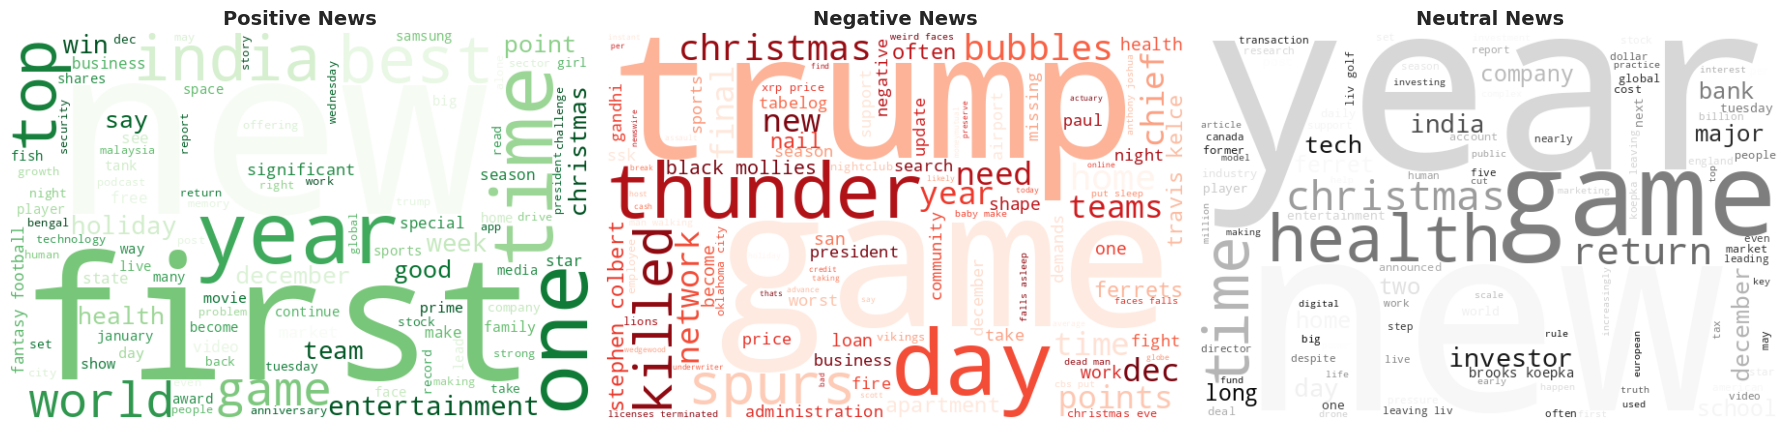

In [17]:
# Word clouds for each sentiment
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sentiments = ['positive', 'negative', 'neutral']
colors = ['Greens', 'Reds', 'Greys']

for idx, (sentiment, color) in enumerate(zip(sentiments, colors)):
    text = ' '.join(df_processed[df_processed['sentiment'] == sentiment]['processed_text'])

    wordcloud = WordCloud(
        width=600, height=400,
        background_color='white',
        colormap=color,
        max_words=100
    ).generate(text)

    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'{sentiment.capitalize()} News', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

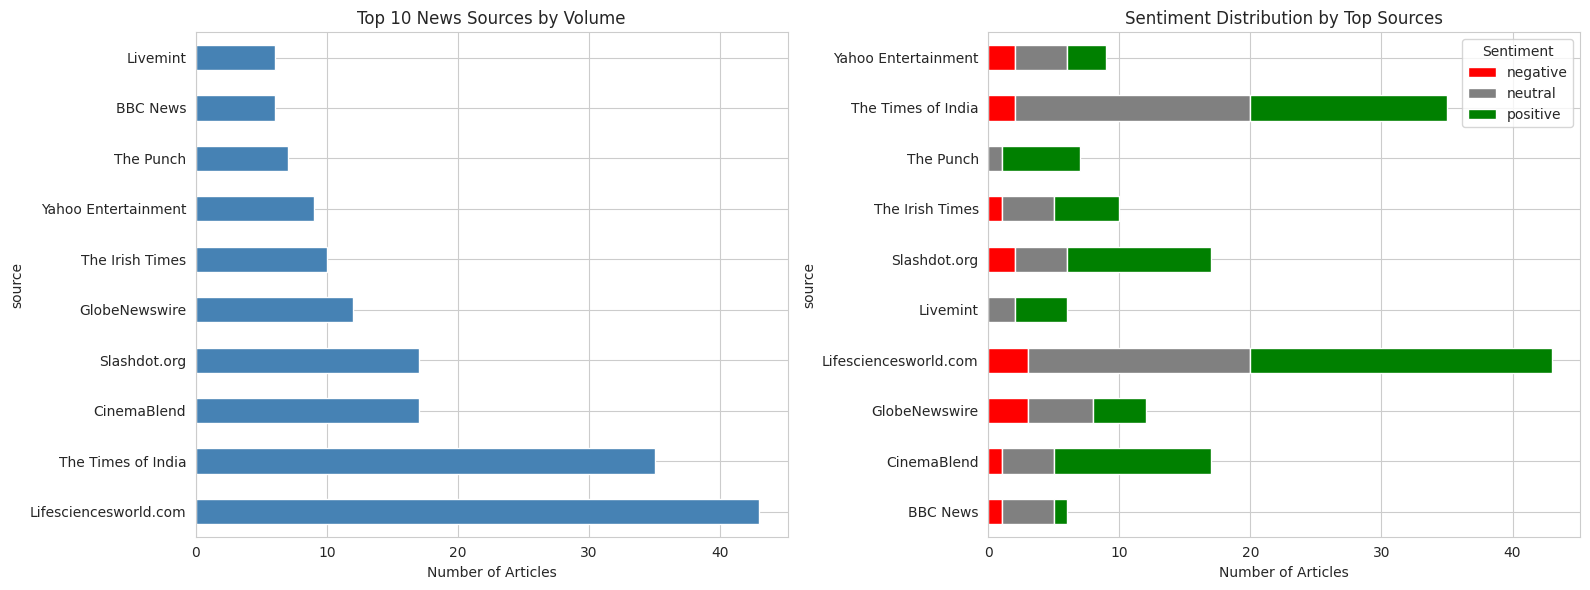

In [18]:
# Top sources by volume and sentiment
top_sources = df_processed['source'].value_counts().head(10).index

source_sentiment = df_processed[df_processed['source'].isin(top_sources)].groupby(
    ['source', 'sentiment']
).size().unstack(fill_value=0)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Volume
df_processed['source'].value_counts().head(10).plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Top 10 News Sources by Volume')
axes[0].set_xlabel('Number of Articles')

# Sentiment
source_sentiment.plot(kind='barh', stacked=True, ax=axes[1],
                      color=['red', 'gray', 'green'])
axes[1].set_title('Sentiment Distribution by Top Sources')
axes[1].set_xlabel('Number of Articles')
axes[1].legend(title='Sentiment')

plt.tight_layout()
plt.show()

In [19]:
print("=" * 60)
print(" PROJECT SUMMARY & KEY INSIGHTS")
print("=" * 60)

print(f"\n1️ Dataset Overview:")
print(f"   • Total articles analyzed: {len(df_processed)}")
print(f"   • Categories covered: {df_processed['category'].nunique()}")
print(f"   • Unique sources: {df_processed['source'].nunique()}")
print(f"   • Date range: 7 days")

print(f"\n2️ Sentiment Analysis:")
sentiment_dist = df_processed['sentiment'].value_counts()
for sentiment, count in sentiment_dist.items():
    pct = (count / len(df_processed)) * 100
    print(f"   • {sentiment.capitalize()}: {count} ({pct:.1f}%)")

print(f"\n3️ Model Performance:")
print(f"   • Algorithm: {model_name}")
print(f"   • Accuracy: {max(nb_accuracy, lr_accuracy):.2%}")
print(f"   • Features used: {X.shape[1]} TF-IDF features")

print(f"\n4️ Topic Clustering:")
print(f"   • Number of clusters: {optimal_k}")
print(f"   • Algorithm: K-Means")

print(f"\n5️ Most Positive Category:")
avg_polarity_by_cat = df_processed.groupby('category')['polarity'].mean().sort_values(ascending=False)
print(f"   • {avg_polarity_by_cat.index[0]}: {avg_polarity_by_cat.values[0]:.3f} avg polarity")

print(f"\n6️ Most Negative Category:")
print(f"   • {avg_polarity_by_cat.index[-1]}: {avg_polarity_by_cat.values[-1]:.3f} avg polarity")

print("\n" + "=" * 60)

 PROJECT SUMMARY & KEY INSIGHTS

1️ Dataset Overview:
   • Total articles analyzed: 432
   • Categories covered: 5
   • Unique sources: 196
   • Date range: 7 days

2️ Sentiment Analysis:
   • Positive: 215 (49.8%)
   • Neutral: 175 (40.5%)
   • Negative: 42 (9.7%)

3️ Model Performance:
   • Algorithm: Logistic Regression
   • Accuracy: 60.92%
   • Features used: 1000 TF-IDF features

4️ Topic Clustering:
   • Number of clusters: 6
   • Algorithm: K-Means

5️ Most Positive Category:
   • entertainment: 0.166 avg polarity

6️ Most Negative Category:
   • health: 0.105 avg polarity



In [20]:
# Save final dataset
df_processed.to_csv('news_sentiment_analysis_results.csv', index=False)

print(" Downloading results...\n")

# Download file
from google.colab import files
files.download('news_sentiment_analysis_results.csv')

print("✓ File downloaded successfully!")
print("\nYour dataset includes:")
print("  • Original text and processed text")
print("  • Sentiment labels and polarity scores")
print("  • Topic clusters")
print("  • Source and category information")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ File downloaded successfully!

Your dataset includes:
  • Original text and processed text
  • Sentiment labels and polarity scores
  • Topic clusters
  • Source and category information
